Testing HJB_V algorithm

In [1]:
import auxil as ax
import numpy as np
import scipy.interpolate as interp
from scipy import optimize
#from numba import jit

In [2]:
pm = ax.set_modelpar()
pa = ax.set_algopar()
ig = ax.set_init_guesses_global(pa,pm)

In [3]:
phi = ax.phi

In [4]:
pa['HJB_V_tol']

1e-09

In [5]:
V_out = ax.solve_HJB_V(pa,pm,ig)

In [19]:
out = {}
    
d = ax.set_init_guesses_V(pa,pm,ig)
# flow profits as function of q
prof = d['prof']
V0 = d['V0']

# Initial guesses for value functions A(q,m,n) and B(q) 
# are contained in argument ig

zE = pm['xi'] * np.minimum(pa['m_grid_2d'],ig['M0'])
x0 = ig['x0']

zmax = np.ones(V0.shape)

HJB_d = 1
count = 1

V1 = np.ones(V0.shape)
#B1 = np.ones(B0.shape)

while (HJB_d > pa['HJB_V_tol'])  count <= 100:  
    # First step is to create interpolant
    V0_interp = interp.Rbf(pa['q_grid_2d'],pa['m_grid_2d'],V0)
    V0plus = V0_interp((1+pm['lambda'])*pa['q_grid_2d'],np.zeros(pa['m_grid_2d'].shape))
   #B0_interp = interp.Rbf(pa['q_grid_3d'],pa['m_grid_3d'],pa['n_grid_3d'],B0)

    # Interpolate onto finer grid 
    #A0_FINE = A0_interp(pa['q_grid_3d_FINE'],pa['m_grid_3d_FINE'],pa['n_grid_3d_FINE'])
    #B0_FINE = B0_interp(pa['q_grid_3d_FINE'],pa['m_grid_3d_FINE'],pa['n_grid_3d_FINE'])

    # Next, loop through all values - no way to avoid, since we need
    # to find the zero of a polynomial to perform the optimization on 
    # the RHS

    #################################################################################
    #Should be able to parallelize below, however. No reason to do this in sequence!#
    #################################################################################

    for i_q,q in enumerate(pa['q_grid']):   
        for i_m,m in enumerate(pa['m_grid']):    


            # Should probably rewrite this as a function and jit THIS, 
            # so that it runs once and figures out what its types should be.
            # If I understand how numba works correctly...

            # Use interpolation + finite difference to compute all derivative terms on the RHS
            # Upwind scheme: take forward difference when drift is positive, backward difference when drift 
            # is negative. Hence, take backward difference when computing Vq, forward difference when computing Vm

            Vq = pa['delta_q']**(-1) * (-1)*(V0_interp(q-pa['delta_q'],m) - V0[i_q,i_m])  
            Vm = pa['delta_m']**(-1) * (V0_interp(q,m + pa['delta_m']) - V0[i_q,i_m])

            # Construct anonymous function for maximizing

            rhs = lambda z: -(x0[i_q,i_m]*(-ig['w0'][i_q,i_m] * z + pm['nu'] * Vm * z + pm['chi_I'] * z * phi(z + zE[i_q,i_m]) * (V0plus[i_q,i_m] - V0[i_q,i_m]) 
                                            + pm['chi_E']*zE[i_q,i_m]*phi(z + zE[i_q,i_m])*(-V0[i_q,i_m])) 
                                + (1 - x0[i_q,i_m]) * (-pm['wbar'] * z + pm['chi_I']*z*phi(z + zE[i_q,i_m])*(V0plus[i_q,i_m] 
                                - V0[i_q,i_m]) + pm['chi_E']*zE[i_q,i_m]*phi(z+zE[i_q,i_m])*(-V0[i_q,i_m])))

            #rhs = lambda z: -( - x0[i_q,i_m] * ig['w0'][i_q,i_m] * z 
            #                 + pm['chi_I']*z*phi(z+zE[i_q,i_m])*V0plus[i_q,i_m] 
            #                 - (pm['chi_I']*z + pm['chi_E']*zE[i_q,i_m])*phi(z+zE[i_q,i_m])*V0[i_q,i_m] 
            #                 + (1- x0[i_q,i_m]) *  pm['nu']*z*Vm )

            optimum = optimize.minimize(rhs,1,bounds = [(0.001,10)], method = 'L-BFGS-B', options={'maxiter': 100, 'disp': True})
            zmax[i_q,i_m] = optimum.x
            z = optimum.x
            #zmax = 0.5
            # Update 

            V1[i_q,i_m] = ( V0[i_q,i_m] 
                                + pa['delta_t']*(-rhs(z) + prof[i_q,i_m] - ig['g0']*q*Vq 
                                + pm['nu']*zE[i_q,i_m] * Vm - (pm['rho'] -ig['g0']) * V0[i_q,i_m]))

    # Compute distance between A0 and A1

    HJB_d = np.sum(np.square(V0-V1)) 

    # Update guesses
    V0 = V1
    #B0 = B1

    count = count + 1

V1_interp = interp.Rbf(pa['q_grid_2d'],pa['m_grid_2d'],V0)
Vplus = V1_interp((1+pm['lambda'])*pa['q_grid_2d'],np.zeros(pa['m_grid_2d'].shape))

out['V'] = V0
out['Vplus'] = Vplus
out['zI'] = zmax
out['count'] = count
#out['B0'] = B0
#return out

Make plots

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')

In [8]:
ax2.plot_surface(pa['q_grid_2d'],pa['m_grid_2d'],V_out['V'])

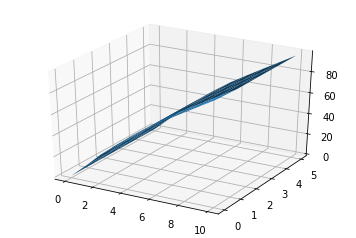

In [9]:
plt.show()

In [10]:
count

NameError: name 'count' is not defined

In [14]:
10e8*HJB_d

0.0